In [1]:
import os
import sys
import torch
from torch import nn

from conditional_rate_matching.models.metrics.crm_metrics_utils import log_metrics
from conditional_rate_matching.configs.config_crm import Config as ConditionalRateMatchingConfig

from conditional_rate_matching.models.generative_models.crm import uniform_pair_x0_x1
from conditional_rate_matching.models.generative_models.crm import conditional_probability
from conditional_rate_matching.models.generative_models.crm import telegram_bridge_probability
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders
from torch.utils.data import DataLoader, TensorDataset

from conditional_rate_matching.models.generative_models.crm import (
    CRM,
    ConditionalBackwardRate,
    ClassificationBackwardRate
)

from conditional_rate_matching.configs.config_files import create_experiment_dir

20it [00:01, 12.72it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 138.91it/s]


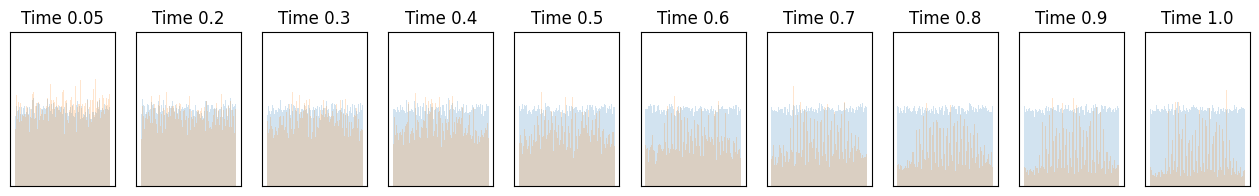

{}

In [4]:
device = torch.device("cpu")
experiment_dir = create_experiment_dir(experiment_name="crm",
                                       experiment_type="mnist",
                                       experiment_indentifier="save_n_loads3")

crm = CRM(experiment_dir=experiment_dir,device=device)
log_metrics(crm,
            epoch=None,
            metrics_to_log=["binary_paths_histograms"],
            where_to_log={"binary_paths_histograms":None})

In [5]:
batch_1, batch_0 = next(zip(crm.dataloader_1, crm.dataloader_0).__iter__())
x_0 = batch_0[0].to(device)
x_1 = batch_1[0].to(device)
time = torch.rand((x_0.size(0))).to(device)

In [13]:
x_0.shape

torch.Size([128, 784])

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Contracting Path
        self.enc_conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Expanding Path
        self.up = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
        # Final Layer
        self.final = nn.Conv2d(64, 10, kernel_size=1)
    
    def forward(self, x):
        # Contracting Path
        x1 = F.relu(self.enc_conv1(x))
        x2 = self.pool(x1)
        x3 = F.relu(self.enc_conv2(x2))
        
        # Expanding Path
        x4 = self.up(x3)
        x5 = torch.cat([x4, x1], dim=1)  # Skip connection
        x6 = F.relu(self.dec_conv1(x5))
        
        # Final Layer (classification layer)
        out = self.final(x6)
        
        # If you're doing segmentation you would upsample to the original MNIST image size
        # If you're classifying, an average pooling could be applied followed by a softmax
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)  # Flatten the tensor
        return F.log_softmax(out, dim=1)